<a href="https://colab.research.google.com/github/hanglee1711/Stock-Price-Analysis-and-Prediction/blob/main/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install pmdarima
!pip install plotly

1. Import libraries

In [54]:
# Importing libraries
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# All necessary plotly libraries
import plotly as plotly
import plotly.io as plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Stats tools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import math

# LSTM
from tensorflow import keras
from tensorflow.keras.layers import Dense,LSTM,Dropout,Flatten
from tensorflow.keras import Sequential



2. Import and explore the dataset

In [7]:
df = pd.read_csv('H4TF_ HPG Data.csv')
df.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,03/31/2023,"18,909.0","18,909.0","19,000.0","18,500.0",26.15M,0.00%
1,03/30/2023,"18,909.0","19,091.0","19,227.0","18,864.0",23.05M,0.00%
2,03/29/2023,"18,909.0","18,818.0","19,182.0","18,818.0",19.74M,0.48%
3,03/28/2023,"18,818.0","19,000.0","19,091.0","18,818.0",13.56M,-0.48%
4,03/27/2023,"18,909.0","18,545.0","19,000.0","18,500.0",22.29M,1.96%


#**A. Exploratory Data Analyst (EDA)**

In [8]:
df.tail(5)

,Date,Price,Open,High,Low,Vol.,Change %
1303,01/08/2018,"12,443.5","11,991.0","12,443.5","11,940.7",14.19M,3.13%
1304,01/05/2018,"12,066.4","12,091.6","12,179.6","11,978.4",14.03M,-0.42%
1305,01/04/2018,"12,116.7","12,016.2","12,167.0","11,965.9",17.79M,1.26%
1306,01/03/2018,"11,965.9","12,066.4","12,192.1","11,890.5",18.51M,-0.21%
1307,01/02/2018,"11,991.0","11,789.9","12,003.6","11,676.8",15.73M,1.81%


In [9]:
df.shape

(1308, 7)

In [10]:
#Checking the data types of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308 entries, 0 to 1307
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1308 non-null   object
 1   Price     1308 non-null   object
 2   Open      1308 non-null   object
 3   High      1308 non-null   object
 4   Low       1308 non-null   object
 5   Vol.      1308 non-null   object
 6   Change %  1308 non-null   object
dtypes: object(7)
memory usage: 71.7+ KB


3. Data cleaning

In [11]:
# Check for missing values
print(" Missing values:")
print(df.isnull().sum())

 Missing values:
Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


In [12]:
# Check for duplicates
print(" Number of duplicates:", df.duplicated().sum())

 Number of duplicates: 0


In [13]:
# Convert format of Date in to Datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308 entries, 0 to 1307
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1308 non-null   datetime64[ns]
 1   Price     1308 non-null   object        
 2   Open      1308 non-null   object        
 3   High      1308 non-null   object        
 4   Low       1308 non-null   object        
 5   Vol.      1308 non-null   object        
 6   Change %  1308 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 71.7+ KB


In [15]:
# Setting date feature as our index
df = df.set_index(df['Date']).sort_index()
print(df.shape)
df.sample(100)

(1308, 7)


,Date,Price,Open,High,Low,Vol.,Change %
Date,,,,,,,
2020-05-05,2020-05-05,"9,790.9","9,790.9","9,905.3","9,745.1",12.41M,1.90%
2019-01-14,2019-01-14,"10,311.8","10,347.0","10,364.6","10,153.4",8.83M,-0.17%
2020-08-07,2020-08-07,"13,491.9","13,380.4","13,547.6","13,352.5",21.35M,0.62%
2021-11-24,2021-11-24,"36,819.5","37,462.8","37,614.2","36,706.0",35.26M,-1.82%
2020-04-07,2020-04-07,"8,692.8","8,715.7","8,738.6","8,349.7",16.12M,0.80%
...,...,...,...,...,...,...,...
2021-04-26,2021-04-26,"30,719.1","31,499.7","31,555.4","30,663.4",44.15M,-2.31%
2021-09-21,2021-09-21,"38,446.7","38,295.3","38,749.4","37,992.6",37.50M,-0.97%
2019-11-18,2019-11-18,"10,477.2","10,385.7","10,522.9","10,385.7",8.08M,1.10%


In [16]:
# Hàm chuyển đổi chuỗi số với dấu phẩy thành số float
def convert_to_float(value):
    try:
        return float(value.replace(',', ''))
    except AttributeError:
        return value

# Convert 'Price', 'Open', 'High', 'Low' to float64 type
for column in ['Price', 'Open', 'High', 'Low']:
    df[column] = df[column].apply(convert_to_float).astype('float64')

# Convert 'Vol.' to int64 (elimnate 'M' character and convert to number)
df['Vol.'] = df['Vol.'].str.replace('M', '').astype(float) * 1_000_000
df['Vol.'] = df['Vol.'].astype('int64')

# Show datatype
print(df.dtypes)
print(df)

Date        datetime64[ns]
Price              float64
Open               float64
High               float64
Low                float64
Vol.                 int64
Change %            object
dtype: object
                 Date    Price     Open     High      Low      Vol. Change %
Date                                                                        
2018-01-02 2018-01-02  11991.0  11789.9  12003.6  11676.8  15730000    1.81%
2018-01-03 2018-01-03  11965.9  12066.4  12192.1  11890.5  18510000   -0.21%
2018-01-04 2018-01-04  12116.7  12016.2  12167.0  11965.9  17790000    1.26%
2018-01-05 2018-01-05  12066.4  12091.6  12179.6  11978.4  14030000   -0.42%
2018-01-08 2018-01-08  12443.5  11991.0  12443.5  11940.7  14190000    3.13%
...               ...      ...      ...      ...      ...       ...      ...
2023-03-27 2023-03-27  18909.0  18545.0  19000.0  18500.0  22290000    1.96%
2023-03-28 2023-03-28  18818.0  19000.0  19091.0  18818.0  13560000   -0.48%
2023-03-29 2023-03-29  1890

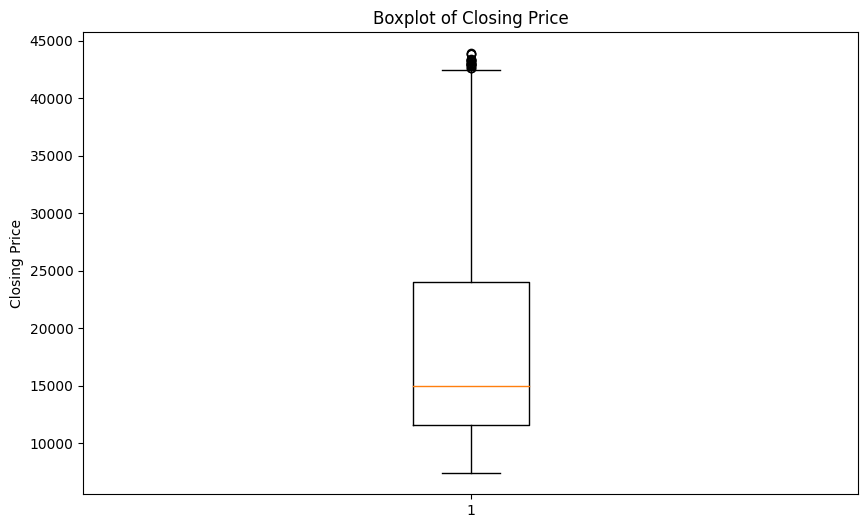

In [17]:
plt.figure(figsize=(10, 6))
plt.boxplot(df['Price'])
plt.title('Boxplot of Closing Price')
plt.ylabel('Closing Price')
plt.show()

The price is concentrated between 11,000 and 24,000, with a median around 15,000. The interquartile range (IQR) spans from 10,000 to approximately 44,000. The closing prices of HPG are right-skewed and asymmetric. There are many outliers located above the upper bound of the closing prices. The box plot indicates a right skew (positive skew).

In [18]:
# Handle outliers
q1 = df['Price'].quantile(0.25)
q3 = df['Price'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
df = df[df['Price'] <= upper_bound]

In [19]:
df.tail(5)

,Date,Price,Open,High,Low,Vol.,Change %
Date,,,,,,,
2023-03-27,2023-03-27,18909.0,18545.0,19000.0,18500.0,22290000,1.96%
2023-03-28,2023-03-28,18818.0,19000.0,19091.0,18818.0,13560000,-0.48%
2023-03-29,2023-03-29,18909.0,18818.0,19182.0,18818.0,19740000,0.48%
2023-03-30,2023-03-30,18909.0,19091.0,19227.0,18864.0,23050000,0.00%
2023-03-31,2023-03-31,18909.0,18909.0,19000.0,18500.0,26150000,0.00%


4. Data visualization

*4.1. Visualize the Closing Price*

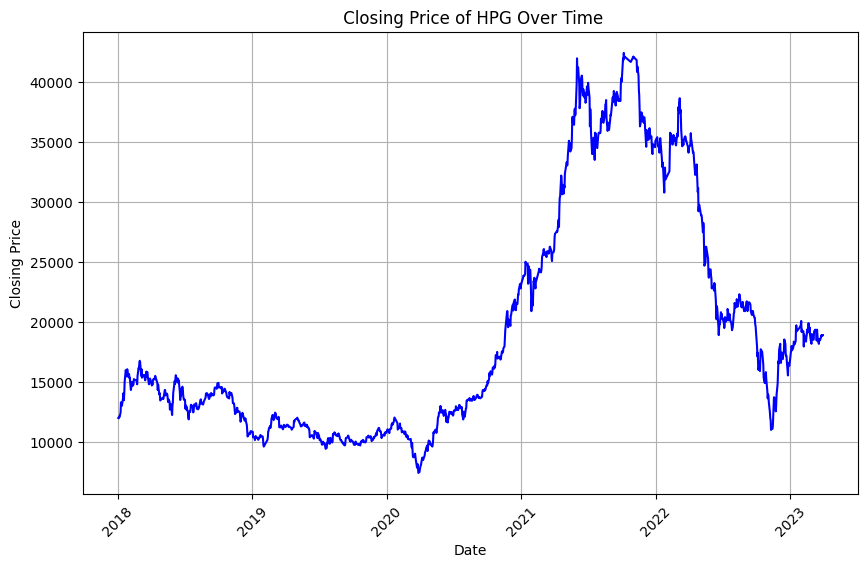

In [20]:
# Plotting the closing price over time
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Price'], color='blue')
plt.title(' Closing Price of HPG Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [21]:
try:
    fig = px.line(df, x=df.index, y="Price", title="Closing Price: Range Slider and Selectors")
    fig.update_xaxes(rangeslider_visible=True, rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])))
    fig.show()
except ValueError as ve:
    print(f"ValueError: {ve}")
except Exception as e:
    print(f"An error occurred while plotting: {e}")

- Highest price: 43.8 in Oct 2021
- Lowest price: 7.4 in Mar 2020

Observing the chart above, we can identify 4 prominent periods based on the fluctuations in the stock's closing price.

**1. Period 1: 2018 to early 2020**
- Price: 10.00 - 15.00
- During this period, the stock price was quite stable, fluctuating slightly around 10.00 - 15.00. There were no major fluctuations, and the market appeared stable with no sudden increases or decreases in price.
- Causes:
 + At the beginning of 2018, the steel industry had favorable growth prospects.
 + From mid-2018 to early 2020, there was a slight decline and stagnation => Global economic crisis, rising input costs leading to higher operating costs; government tightening policies on real estate and securities.

**2. Period 2: Early 2020 to late 2020**
- Price: 10.00 - 20.00
- Starting from early 2020, the stock price began to grow, rising from around 10k to about 20.00. Although there were fluctuations, the main trend was upward.
- Causes:
 + Q1/2020 - Q3/2020: Hitting the bottom at 7.40 in Q3 => Due to the impact of the first wave of Covid-19, many investors panicked and fled the stock market, causing a significant downturn in VN INDEX overall.
 + End of Q3/2020 - End of 2020: This period saw the recovery of VN INDEX. Moreover, it was a phase where core business operations benefited, evidenced by improved gross profit margins. Public investment was boosted, and real estate and construction developed, enabling Hoa Phat to sell more goods and improve cost prices. Additionally, part of the Dung Quat 1 project commenced operations at the end of March, particularly the introduction of HRC products to the market further stimulated HPG's growth.

**3. Period 3: 2021 to mid-2022**
- Price: 20.00 - 45.00
- This was the period of the most significant growth. The stock price continuously increased, peaking around mid-2021 at approximately 45k. This was a time of rapid and substantial growth in the stock price.
- Causes:
 + From Q2/2021 to Q3/2021: Sharp Increase, Price Doubled (from 20.00 to 40.00)
   + Dung Quat 1 almost fully operational, leading to a strong increase in steel production, especially HRC reaching 1.3 million tons. Particularly during this period, steel prices were robust, aiding HPG's development.
   + In the first half of the year, revenue was equal to 70% of 2020, and the gross profit margin reached 30%, which was very high.
 + Q4/2021 (Peak 43.8): Price collapse
   + Input costs have increased: 2 major raw materials (ore, coal) - China's energy crisis => phenomenon of accumulation, speculation on coal in a range of countries, => supply shortage; Freight rates of goods transportation world continuously increased
   + The export market has narrowed: Coal shortage (reduced output); China's environmental policy for the Beijing Olympic Games - China strictly controls pollution-causing projects
 + Early 2022 - mid-2022: There were significant reductions => steel prices did not rise anymore and were affected by social distancing, causing public investment activities, real estate, and construction to be sluggish, with HPG's dealers yet to plan to import more inventory for sale.

**4. Period 4: Mid-2022 to early 2023**
- Price: 20.00 - 30.00
- After peaking in mid-2021, the stock price began to decline sharply, dropping to around 20.00 by early 2023. Afterwards, the stock price gradually stabilized at around 20.00 - 30.00.
- Causes:
 + From Q3/2022 to the end of 2022, the stock price began to decline, hitting a low of 11.00 in November 2022.
   + World steel prices plummeted sharply from May 2022 due to weakening steel demand in major markets such as China, the US, and Europe. Bank interest rates rose.
   + Coal prices surged dramatically due to the crisis stemming from political conflicts, exacerbated by slow consumption and low selling prices due to weak demand, putting significant pressure on the cost of goods sold. The energy crisis from the Russia-Ukraine conflict drove coke coal prices, one of the two main ingredients for blast furnace steelmaking, to three times the usual peak levels in March and May 2022. These elevated prices persisted at about 1.5 times higher than 2021 levels throughout the remainder of 2022. As a result, the gross profit margin declined from 27% in 2021 to 12% in 2022.
   + The company also closed 4 blast furnaces, reducing steel production capacity to decrease the inventory of high-priced finished goods, aligning with market demand.
 + Subsequently, the stock price showed signs of slight recovery but remained low compared to the beginning of 2022.



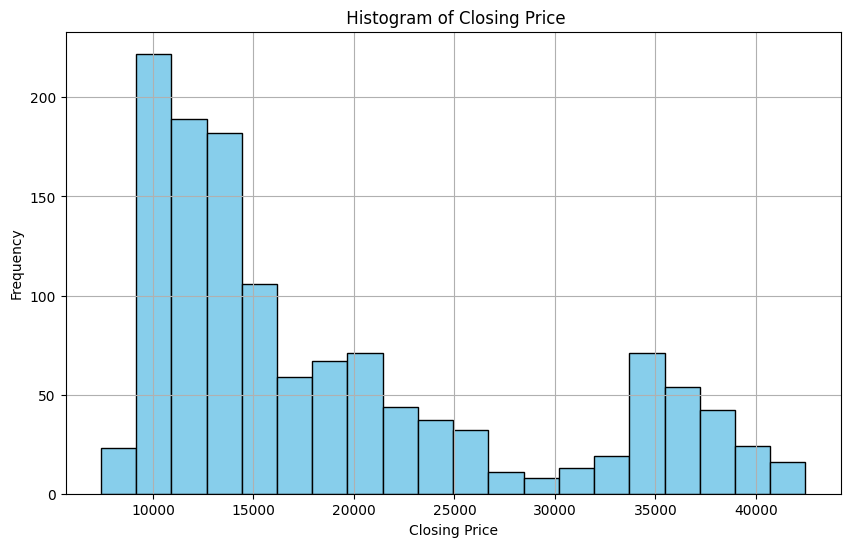

In [22]:
# Histogram of closing prices
plt.figure(figsize=(10, 6))
plt.hist(df['Price'], bins=20, color='skyblue', edgecolor='black')
plt.title(' Histogram of Closing Price')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

**1. Uneven distribution**
- The distribution of HPG stock prices is uneven, with certain price ranges appearing more frequently than others.
- The price range from 10.00 to 15.00 has the highest frequency, indicating that HPG stock prices often fell within this range from 2018 to early 2023.
- The price distribution from 2018 to early 2022 is heavily skewed towards lower prices, with more dispersion at higher price levels.

**2. Prominent Price Ranges**
- 10.00 to 15.00: This range has the highest frequency, with a noticeable peak around 10.00 - 12.00. This suggests that during this period, HPG stock was frequently traded at lower prices, influenced by the global economic crisis in 2018 and the impact of COVID-19 from 2019 to late 2020, causing the stock price to fluctuate below 15.00 for an extended period.
- 20.00 to 25.00: There are several days when HPG stock prices fell within this range, but the frequency is lower compared to the 10.00 to 15.00 range.
- 35.00 to 40.00: There are a few instances where the stock price reached this high range, indicating periods of significant price spikes.

**3. Price Volatility**
- The histogram illustrates considerable price volatility for HPG stock, with prices spanning a wide range from 10.00 to 45.00.
- This volatility could be due to external factors such as market fluctuations, economic conditions, or events related to the company.

**4. Outliers**
- Some values appear at high prices (35.00 to 45.00), which could be considered outliers during this period. This indicates there are times when HPG stock prices spike significantly, possibly due to important events or positive company information.

In summary, HPG stock prices from 2018 to early 2023 show uneven distribution, with most of the time prices ranging between 10.00 and 15.00. There is considerable price volatility, with periods where stock prices reach sudden highs. This may reflect overall market volatility and specific factors related to HPG during this period.



*4.2. Visualize the Trading Volume*

In [23]:
# Trading volume overtime
try:
    import plotly.express as px

    fig = px.line(df, x=df.index, y="Vol.", title="Trading Volume over Time")
    fig.update_xaxes(rangeslider_visible=True, rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    ))
    fig.update_layout(title='Trading Volume over Time', xaxis_title='Date', yaxis_title='Volume')

    # Customizing the plot layout
    fig.update_traces(line=dict(width=2, color='blue'))  # Change line width and color
    fig.update_layout(plot_bgcolor='white', xaxis_gridcolor='lightgray', yaxis_gridcolor='lightgray')  # Set background and grid colors
    fig.update_layout(font=dict(family="Arial", size=12, color="black"))  # Font settings

    fig.show()
except ValueError as ve:
    print(f"ValueError: {ve}")
except Exception as e:
    print(f"An error occurred while plotting: {e}")

Observing the chart, we can see that the trading volume fluctuation from January 2018 to October 2020 was relatively stable, and then suddenly increased sharply in November 2020. Beginning from November 2020 to March 2023, the trading volume fluctuation was high, and the stock price showed a strong upward trend.

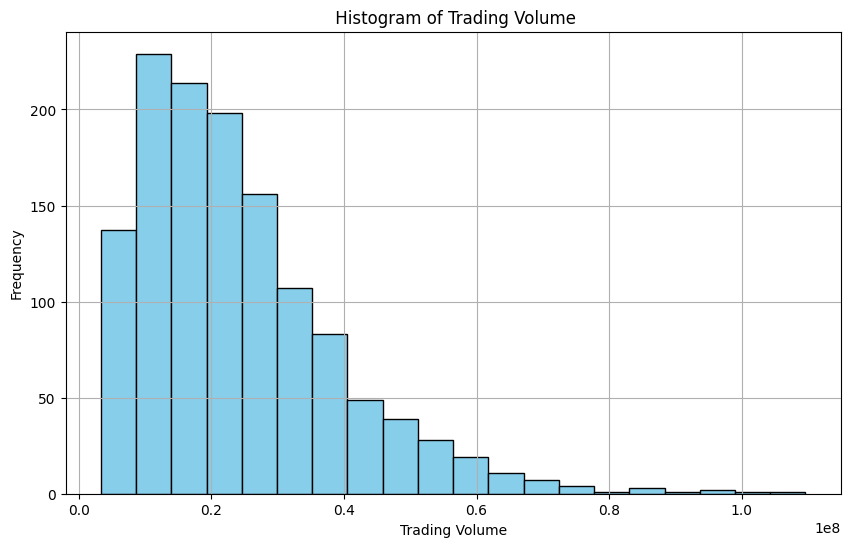

In [24]:
# Histogram of trading volume
plt.figure(figsize=(10, 6))
plt.hist(df['Vol.'], bins=20, color='skyblue', edgecolor='black')
plt.title(' Histogram of Trading Volume')
plt.xlabel('Trading Volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Observations:
1. Distribution Shape:
   - The histogram shows a right-skewed distribution (positive skew), meaning most of the trading volumes are concentrated on the left side (lower values), with a long tail extending to the right (higher values).

2. Frequency and Range:
   - The highest frequency of trading volumes is observed in the range between 0 and 0.1 x 10^8.
   - The frequency gradually decreases as the trading volume increases.

3. Central Tendency:
   - The mode (the most frequently occurring trading volume) appears to be within the 0.1 x 10^8 to 0.2 x 10^8 range, with the highest peak around this range.
   - There is a significant drop-off in frequency after the 0.2 x 10^8 range.

4. Outliers:
   - There are some outliers in the higher trading volume ranges (above 0.6 x 10^8), but they occur with very low frequency.

Interpretation:
1. Trading Activity:
  - Most trading activities for HPG stock occur at lower volumes, suggesting that the stock is frequently traded in smaller amounts.
  - Higher trading volumes are rare, indicating fewer instances of large trades.

2. Market Behavior:
  The right-skewed nature of the histogram suggests that while the stock is often traded in smaller quantities, there are occasional large trades that could significantly impact the stock price or indicate institutional interest or major market moves.


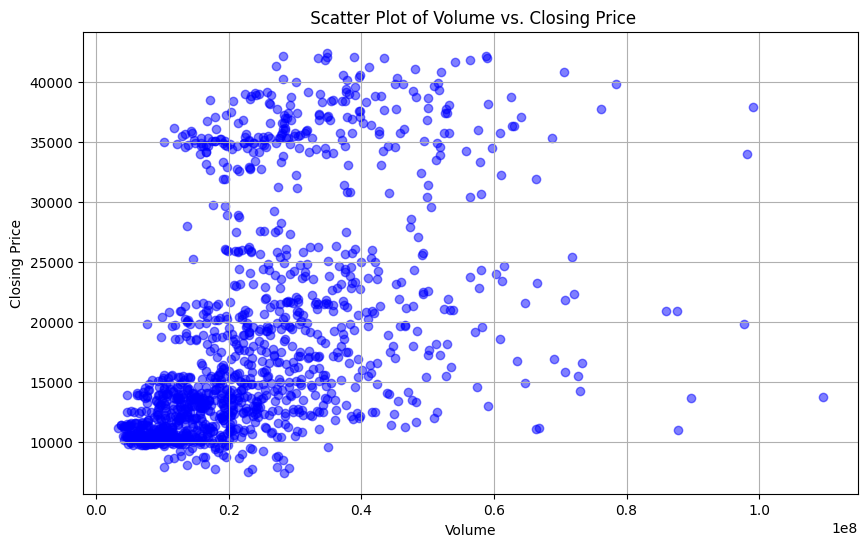

In [25]:
# Scatter plot of volume vs. closing price
plt.figure(figsize=(10, 6))
plt.scatter(df['Vol.'], df['Price'], color='blue', alpha=0.5)
plt.title(' Scatter Plot of Volume vs. Closing Price')
plt.xlabel('Volume')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

- There is a positive correlation between volume and closing price. This means that when trading volume increases, stock prices also tend to increase.
- The correlation coefficient between volume and closing price is 0.52, indicating a moderate correlation. This means that the upward trend in stock prices with increasing trading volume is not always strong and clear; stock prices are still influenced by other factors.
- The data is unevenly distributed on the chart. There is a cluster of data in the bottom left corner of the chart, where stock prices are low (10.00 to 17.00) and trading volume is low (0.1 to 0.3); and in the top left corner of the chart, where stock prices are high (35.00 to 39.00) and trading volume is low (0.1 to 0.4).
- There are a few points that are quite far from the main cluster, indicating that there are trading days with very high volumes but low closing prices, and vice versa.

The analysis reveals a positive correlation between trading volume and closing prices of the HPG stock, with a correlation coefficient of 0.52 indicating a moderate relationship. This suggests that while stock prices generally tend to rise with increasing trading volumes, other factors also significantly influence the prices. The data distribution is uneven, with clusters showing low prices and low volumes, as well as high prices and low volumes. Additionally, there are outliers indicating days with high trading volumes but low closing prices.


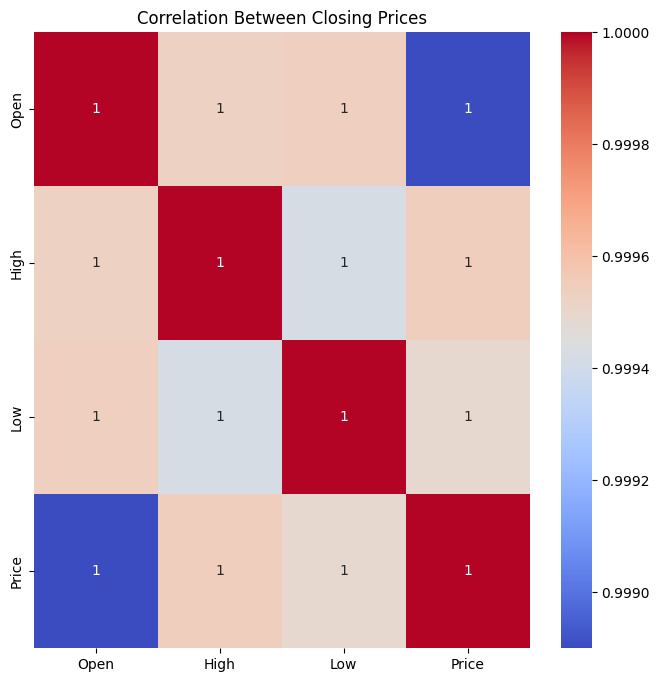

In [26]:
# Create a heatmap of the correlation between stock prices
corr = df[['Open', 'High', 'Low', 'Price']].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Between Closing Prices')
plt.show()

The heatmap indicates correlation between types of prices with each one of them. All of the coefficients are close to one, suggesting strong correlation and that the opening, high, low, and closing prices move very closely together. When one of the prices go up, it is very likely that other prices also go up and vice versa.

*4.3. Visualize Returns*

In [27]:
# Daily return
df['Daily_Return'] = df['Price'].pct_change() * 100
print(" Daily returns:")
print(df['Daily_Return'].head())

 Daily returns:
Date
2018-01-02         NaN
2018-01-03   -0.209324
2018-01-04    1.260248
2018-01-05   -0.415130
2018-01-08    3.125207
Name: Daily_Return, dtype: float64


In [28]:
# Line chart of daily return
fig = px.line(df, x='Date', y='Daily_Return', title='Daily Returns: Range Slider and Selectors')
fig.update_xaxes(rangeslider_visible=True, rangeselector=dict(
    buttons=list([
        dict(count=1, label="1m", step="month", stepmode="backward"),
        dict(count=6, label="6m", step="month", stepmode="backward"),
        dict(count=1, label="YTD", step="year", stepmode="todate"),
        dict(count=1, label="1y", step="year", stepmode="backward"),
        dict(step="all")
    ])
))

The line chart shows daily returns ranging from -5 to 5, with numerous spikes in both positive and negative directions, suggesting significant volatility and fluctuation in the given period

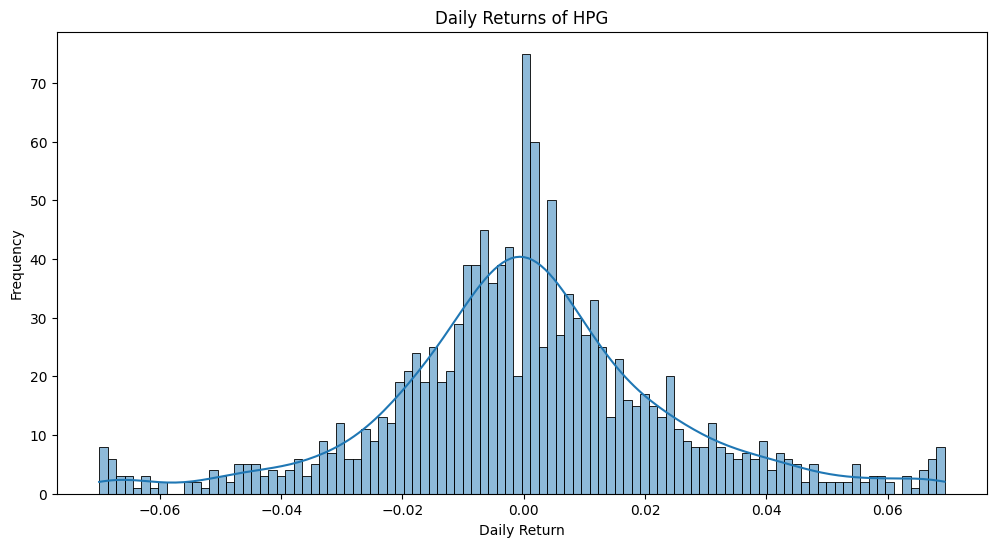

In [29]:
# Histogram of the daily returns
plt.figure(figsize=(12,6))
sns.histplot(df['Price'].pct_change().dropna(), bins=100, kde=True)
plt.title('Daily Returns of HPG')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

As observed in the visual, daily returns have a normal distribution, with volatility spanning from -0.06 and 0.06. The highest frequency bars are near the center, showing that returns close to zero are the most common.

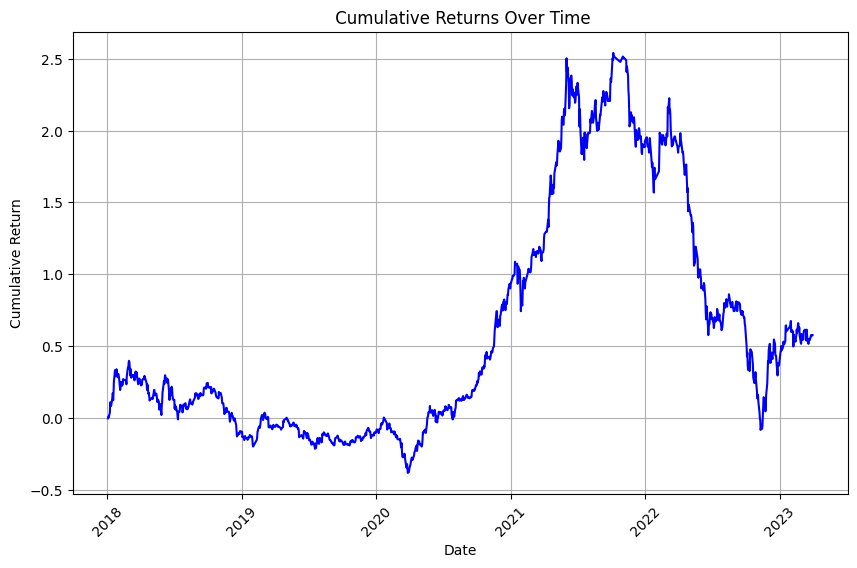

In [30]:
# Cumulative returns overtime
df['Cumulative_Return'] = (1 + df['Daily_Return'] / 100).cumprod() - 1
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Cumulative_Return'], color='blue')
plt.title(' Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

We can clearly see the trend of cumulative return overtime. From the beginning of 2018 to the beginning of 2020, cumulative returns drop, before making a great comeback from 2020 to 2022, then drop in the following years. The trend of cumulative return is similar to that of closing price.
In 2019 and first months of 2020, cumulative return is below zero, which can be explained by the outbreak of Covid-19


*4.4. Visualize the total liquidity*

In [31]:
# Total liquidity by month
df['Month'] = df['Date'].dt.month
monthly_volume = df.groupby('Month')['Vol.'].sum().reset_index()

month_names = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_volume['Month'] = monthly_volume['Month'].apply(lambda x: month_names[x-1])

fig = px.line(monthly_volume, x='Month', y='Vol.', title='Monthly Liquidity',
              labels={'Month': 'Month', 'Vol.': 'Liquidity'})

fig.show()

From the chart, it is evident that liquidity is highest typically in March and December. This may be related to the company's financial activities at the end of the year and the beginning of the new year. Liquidity gradually decreases in the middle months of the year as the market shows signs of stabilization, with the lowest liquidity usually occurring in April. This could be due to the impact of the summer vacation season and a slowdown in business activities during this time.

There is significant fluctuation in liquidity between the months of the year, indicating seasonality in HPG stock trading activities. The monthly liquidity fluctuation pattern remains relatively stable over the years, although the degree of fluctuation may vary from year to year.

In summary, the chart analyzing the monthly liquidity fluctuations of HPG stock during the period from 2018 to 2023 shows a clear seasonality with high liquidity at the beginning and end of the year, and low liquidity in the summer. This fluctuation can impact trading activities and necessitates effective liquidity management for investors.


In [32]:
# Total liquidity by year
df['Year'] = df['Date'].dt.year
yearly_volume = df.groupby('Year')['Vol.'].sum().reset_index()

fig = px.line(yearly_volume, x='Year', y='Vol.', title='Yearly Liquidity',
              labels={'Year': 'Year', 'Vol.': 'Liquidity'})

fig.show()

- Liquidity has shown a significant upward trend from 2018 to 2021, peaking in 2021.
- However, after 2021, liquidity began to decline sharply and continued to decrease in 2021, 2022, and is projected to reach a low level in 2023.
- The volatility of liquidity forms an inverse U-shape, with a peak in 2021 and a gradual decline before and after that year.
- The forecasted liquidity level for 2023 is significantly lower than the highest level achieved in 2021, indicating an increasingly severe liquidity shortage.
- The continuous decline in liquidity in recent years may affect the trading ability and stock price of HPG.

In summary, the chart reflects the trend of HPG's stock liquidity rising to a peak in 2021 but then sharply decreasing in the subsequent years. This indicates a worsening liquidity shortage for this stock, which could affect trading activities and stock valuation in the future if liquidity improvements are not implemented.


*4.5. Candlestick Plots*

In [33]:
fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                                    open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Price'])])
fig.show()

The chart shows a strong and sustained uptrend lasting from 2019 until June 1, 2021. During this period, the stock price consistently made higher highs and higher lows, indicating a bullish sentiment in the market for HPG. The uptrend was particularly steep and volatile from Mar 30, 2020 to late 2021, with the stock price rapidly appreciating.

In Oct 2021, the chart shows a significant reversal pattern, with a series of long red candlesticks indicating a shift in market sentiment from bullish to bearish. Since then, the stock has been in a persistent downtrend, with the price making lower lows and lower highs, reflecting a sustained selling pressure.

During the downtrend, the stock price has encountered potential support levels where the selling pressure temporarily eased or reversed. These potential support areas can be identified around the lows in early 2022 and late 2022/early 2023, where the stock found temporary buying interest before continuing its overall downward trajectory.

*4.6. Indicators*

The list of indicators are:

- Simple Moving Average (Fast and Slow)
- Exponential Moving Average (Fast and Slow)
- Relative Strength Index (RSI)
- Moving Average Convergence Divergence (MACD)

*4.6.1. Simple Moving Average (SMA)*

In [34]:
try:
    df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)
except KeyError:
    print("The 'Price' column is not found in the dataframe. Please check the column names.")
    raise
except Exception as e:
    print(f"An error occurred while converting 'Price' to numeric: {e}")
    raise

# Calculate SMA_5 and SMA_15 (assuming simple moving averages)
df['SMA_100'] = df['Price'].rolling(window=100).mean()
df['SMA_50'] = df['Price'].rolling(window=50).mean()
df['SMA_15'] = df['Price'].rolling(window=15).mean()

# Plotting with Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['SMA_100'], name='SMA_100'))
fig.add_trace(go.Scatter(x=df.index, y=df['SMA_50'], name='SMA_50'))
fig.add_trace(go.Scatter(x=df.index, y=df['SMA_15'], name='SMA_15'))
fig.add_trace(go.Scatter(x=df.index, y=df['Price'], name='Close', opacity=0.3, line=dict(color='dark green')))
fig.update_layout(title='SMA_100, SMA_15, SMA_50, and Close over Time', xaxis_title='Date', yaxis_title='Price')
fig.show()


**1. Uptrend Phase (2019 - June 2021):**
- During this period, the SMA lines (100, 50, and 15) were steadily rising and the shorter SMAs (15 and 50) were above the longer SMA (100), indicating a strong uptrend. The stock price was also consistently trading above all the SMA lines, confirming the bullish momentum.

**2. Golden Cross (Mid-2020):**
- Around mid-2020, the 50-day SMA crossed above the 100-day SMA, forming a "Golden Cross" pattern. This is generally considered a bullish signal and further supported the emerging uptrend in the stock.

**3. Steep Ascent (Late 2020 - Late 2021):**
- During this period, the SMAs displayed a steep ascent, with the stock price rapidly climbing to new highs. The shorter SMAs (15 and 50) led the way, followed by the longer SMA (100), indicating strong and sustained buying pressure.

**4. Bearish Divergence (Early 2022):**
- As the stock price reached its peak at 38.6k in March 2022, the SMAs started to flatten out and diverge from the price, forming a bearish divergence pattern. This divergence often precedes a potential trend reversal.

**5. Downtrend Phase (Mid-2022 - Mar 2023):**
- After the peak in March 2022, the stock price started to decline, and the SMAs turned downward. The shorter SMAs (15 and 50) crossed below the longer SMA (100), forming a "Death Cross" pattern, which is a bearish signal. The stock price also fell below all the SMA lines, confirming the downtrend.

As of March 2023, the downtrend appears to be ongoing, with the SMAs still in a downward trajectory. However, the SMAs are relatively close together, suggesting potential consolidation or a slowing of the downtrend.


*4.6.2. Exponential Moving Average (EMA)*

In [35]:
# Ensure 'Price' column is numeric
try:
    df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)
except KeyError:
    print("The 'Price' column is not found in the dataframe. Please check the column names.")
    raise
except Exception as e:
    print(f"An error occurred while converting 'Price' to numeric: {e}")
    raise

# Calculate EMA_50 and EMA_15
df['EMA_100'] = df['Price'].ewm(span=100, adjust=False).mean()
df['EMA_50'] = df['Price'].ewm(span=50, adjust=False).mean()
df['EMA_15'] = df['Price'].ewm(span=15, adjust=False).mean()

# Plot with Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['EMA_100'], name='EMA_100'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA_50'], name='EMA_50'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA_15'], name='EMA_15'))
fig.add_trace(go.Scatter(x=df.index, y=df['Price'], name='Close', opacity=0.3, line=dict(color='dark green')))
fig.update_layout(title='EMA_15, EMA_50, and Close over Time', xaxis_title='Date', yaxis_title='Price')
fig.show()

**1. Overall Trend:**
- The chart shows an upward trend from 2019 to Nov 2021, where all the EMAs and the close price reached their peaks. This indicates a prolonged bullish period for the stock.

**2. Volatility:**
- There is significant volatility in the price movements, with the close price line showing sharp ups and downs, especially during the peak period in Nov 2021. The shorter EMAs (15 and 50) also exhibit more volatility than the longer EMA (100), as expected.

**3. Divergence:**
- In Nov 2021, the close price starts diverging from the EMAs, indicating a potential reversal in the trend. The close price falls sharply below the EMAs, suggesting a bearish phase for the stock.

**4. Late 2022 and into 2023:**
- The EMAs have converged, with the close price trading below all three EMA levels. This suggests the stock is in a bearish phase, with the potential for further downside if the close price remains below the EMAs.



Compare SMA's and EMA's

In [36]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Ensure 'Price' column is numeric
try:
    df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)
except KeyError:
    print("The 'Price' column is not found in the dataframe. Please check the column names.")
    raise
except Exception as e:
    print(f"An error occurred while converting 'Price' to numeric: {e}")
    raise

# Calculate SMA_50 and EMA_50
df['SMA_50'] = df['Price'].rolling(window=50).mean()
df['EMA_50'] = df['Price'].ewm(span=5, adjust=False).mean()

# Calculate SMA_15 and EMA_15
df['SMA_15'] = df['Price'].rolling(window=15).mean()
df['EMA_15'] = df['Price'].ewm(span=5, adjust=False).mean()

# Create subplots with shared y-axis
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, horizontal_spacing=0.1, subplot_titles=("SMA 50 vs EMA 50", "SMA 15 vs EMA 15"))

# Add traces for SMA_50 and EMA_50 on the first subplot (row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['SMA_50'], name='SMA 50', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['EMA_50'], name='EMA 50', line=dict(color='red')), row=1, col=1)

# Add trace for Price (Close) on the first subplot (row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['Price'], name='Close', opacity=0.3, line=dict(color='darkgreen')), row=1, col=1)

# Add traces for SMA_15 and EMA_15 on the second subplot (row=1, col=2)
fig.add_trace(go.Scatter(x=df.index, y=df['SMA_15'], name='SMA 15', line=dict(color='blue')), row=1, col=2)
fig.add_trace(go.Scatter(x=df.index, y=df['EMA_15'], name='EMA 15', line=dict(color='red')), row=1, col=2)

# Add trace for Price (Close) on the second subplot (row=1, col=2)
fig.add_trace(go.Scatter(x=df.index, y=df['Price'], name='Close', opacity=0.3, line=dict(color='darkgreen')), row=1, col=2)

# Update layout with titles for each subplot
fig.update_layout(
    title='Comparison of SMA_50/EMA_50 and SMA_15/EMA_15 with Price',
    xaxis_title='Date',
    yaxis_title='Price',
    height=600,  # Adjust height as needed
    showlegend=True,  # Show legend
)

# Show the plot
fig.show()


**1. SMA 50 vs EMA 50 (Left Chart)**
- The SMA 50 (blue line) appears smoother and lags behind the EMA 50 (red line).
- The EMA 50 responds more quickly to price changes and aligns more closely with the actual price movements.

**2. SMA 15 vs EMA 15 (Right Chart)**
- Similar to the left chart, the SMA 15 (blue line) is smoother and shows more lag compared to the EMA 15 (red line), though the differences are less pronounced.

**Analysis**:
- SMA (Simple Moving Average):
  - Smooths out price data over a specified period.
  - Lags more as it gives equal weight to all prices in the period.
  - May be better for identifying long-term trends due to its smoothing effect.

-  EMA (Exponential Moving Average):
  - Puts more weight on recent prices, making it more responsive to new information.
  - Less lag compared to SMA, which can make it more useful for short-term predictions and quick reactions to price changes.

**Conclusion**:
Given the characteristics observed in the charts:
- For short-term predictions: The EMA is generally more useful due to its responsiveness to recent price changes. This allows for quicker adjustments and potentially better signals for entry and exit points.
- For long-term trend analysis: The SMA might be preferable due to its smoothing effect, which can help in identifying broader market trends without being as affected by short-term volatility.


*4.6.3. Relative Strength Index (RSI)*


In [37]:
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

def RSI(df, n=14):
    close = df['Price']
    delta = close.diff()
    delta = delta[1:]  # Remove the first NaN value
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

# Calculate RSI and fill NaN values with 0 (optional)
df['RSI'] = RSI(df).fillna(0)

# Plotting RSI with Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['RSI'], name='RSI'))
fig.update_layout(title='Relative Strength Index (RSI) over Time', xaxis_title='Date', yaxis_title='RSI')
fig.show()

RSI had many below 30 points in the 201-2020 period, indicating that HPG stock was more oversold in this period. Conversely, RSI had more above 70 points and less below 30 points, indicating that RSI was more overbought, due to the need to invest in these years. RSI leaned towards being oversold in 2022 and 2023.

*4.6.4. Moving Average Convergence Divergence (MACD)*


In [38]:
df['EMA_12'] = pd.Series(df['Price'].ewm(span=12).mean())
df['EMA_26'] = pd.Series(df['Price'].ewm(span=26).mean())
df['MACD'] = pd.Series(df['EMA_12'] - df['EMA_26'])
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9,min_periods=9).mean())

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date,y=df.MACD,name='MACD'))
fig.add_trace(go.Scatter(x=df.Date,y=df.MACD_signal,name='MACD_signal'))
fig.show()


- 2019-2020: The MACD oscillated around the signal line and near the zero threshold, indicating a sideways market with no clear trend.
- Early 2021 to mid-2022: The MACD line was above the MACD signal line with some high peaks, reflecting a strong upward trend in the stock price during this period.
- Late 2022 to 2023: The MACD line began to fall below the MACD signal line, indicating a downward trend in the HPG stock price. The MACD remains below the signal line, but the gap is not too large, suggesting a temporary downward trend that is not overly strong.

In summary, the MACD analysis of HPG stock reveals distinct phases. From 2019 to 2020, the MACD hovered around the signal line, indicating a sideways market with no clear trend. However, from early 2021 to mid-2022, the MACD stayed above the signal line with significant peaks, reflecting a strong upward trend. Starting from late 2022 into 2023, the MACD fell below the signal line, indicating a downward trend, though the gap between the MACD and the signal line is not very large, suggesting a mild downward trend. Overall, the MACD highlights a strong price increase in early 2021, followed by a persistent downward trend from late 2021 to the present, with potential signs to watch for a trend reversal.


4.7. Time decomposition (Trend, Seasonality, Residuals)

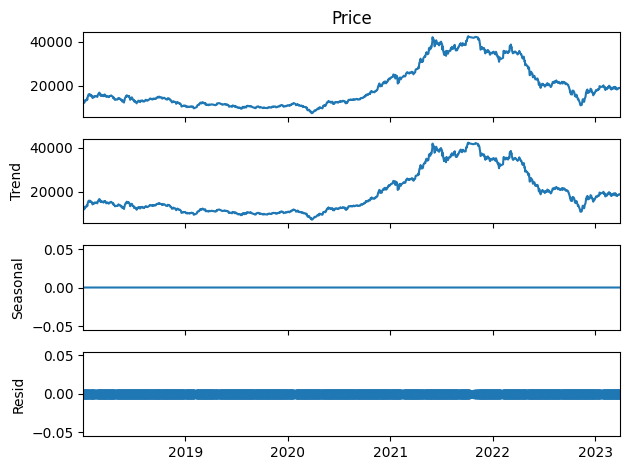

In [39]:
series = df.Price
result = seasonal_decompose(series, model='additive',period=1) # The frequncy is daily
figure = result.plot()

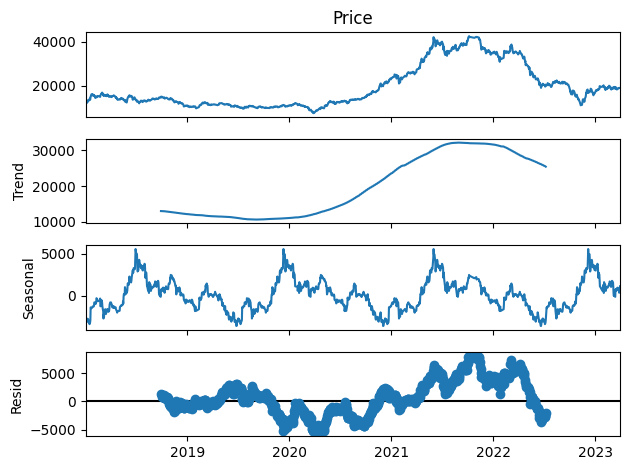

In [40]:
series = df.Price
result = seasonal_decompose(series, model='additive',period=365) # The frequncy is daily
figure = result.plot()

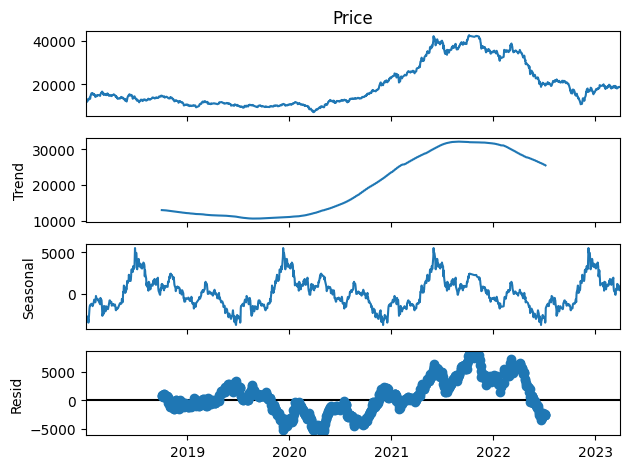

In [41]:
series = df.Price
result = seasonal_decompose(series, model='additive',period=366) # The frequncy is daily
figure = result.plot()

The HPG stock price showed an upward trend from 2019 to early 2022, followed by a gradual decline.

The HPG stock price exhibits mild seasonality, most apparent in the fourth quarter of each year. Investment activities surge at the end of the year due to positive sentiment anticipating the new year, pushing the HPG stock price higher. Investor demand for liquidity increases at the end of the year to realize profits, which can put pressure on the HPG stock price.

The HPG stock price is significantly affected by residuals, as reflected in the residuals:
- Bottom (March 2020): The outbreak of the first phase of Covid-19
- Peak (June 2021 and October 2021): The Dung Quat 1 project became fully operational, leading to a substantial increase in HRC steel production.

The HPG stock price experienced an upward trend from 2019 until early 2022, after which it began to decline gradually. There is mild seasonality in the stock price, particularly noticeable in the fourth quarter due to increased investment activities driven by positive year-end sentiment. This results in a higher stock price, but the need for liquidity at the end of the year can create pressure on the price. The stock price is also significantly impacted by residuals, with notable events such as the Covid-19 outbreak in March 2020 causing a bottom, and the full operation of the Dung Quat 1 project in mid to late 2021 resulting in peaks.


#**B. LSTM**

In [ ]:
df= pd. DataFrame(df, columns = ['Date', 'Price'])
df.index = df.Date
df.drop('Date', axis=1, inplace=True)
df

,Price
Date,
2018-01-02,11991.0
2018-01-03,11965.9
2018-01-04,12116.7
2018-01-05,12066.4
2018-01-08,12443.5
...,...
2023-03-27,18909.0
2023-03-28,18818.0
2023-03-29,18909.0


In [ ]:
df = df.loc['2018-01-02':'2023-03-31']

closing_prices = df['Price']

# Train-test split
train_data = closing_prices[:'2022-02-28']
test_data = closing_prices['2022-03-01':]

In [ ]:
# Min-Max Scale
sc = MinMaxScaler(feature_range=(0,1))
sc_train = sc.fit_transform(df)

In [ ]:
x_train, y_train=[],[]
for i in range(50,len(train_data)):
  x_train.append(sc_train[i-50:i,0])
  y_train.append(sc_train[i,0])

In [ ]:
# Arrange data into a two-dimensional array
x_train = np.array(x_train)
y_train = np.array(y_train)

# Rearrange data into one-dimensional arrays
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

In [ ]:
# Build LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=20)


Epoch 1/20
967/967 [==============================] - 43s 41ms/step - loss: 0.0022
Epoch 2/20
967/967 [==============================] - 39s 41ms/step - loss: 0.0013
Epoch 3/20
967/967 [==============================] - 45s 46ms/step - loss: 9.2762e-04
Epoch 4/20
967/967 [==============================] - 39s 41ms/step - loss: 7.9064e-04
Epoch 5/20
967/967 [==============================] - 40s 41ms/step - loss: 4.7130e-04
Epoch 6/20
967/967 [==============================] - 40s 41ms/step - loss: 7.0472e-04
Epoch 7/20
967/967 [==============================] - 38s 39ms/step - loss: 4.4058e-04
Epoch 8/20
967/967 [==============================] - 39s 41ms/step - loss: 5.3382e-04
Epoch 9/20
967/967 [==============================] - 40s 41ms/step - loss: 4.6670e-04
Epoch 10/20
967/967 [==============================] - 39s 41ms/step - loss: 5.2203e-04
Epoch 11/20
967/967 [==============================] - 40s 41ms/step - loss: 3.7249e-04
Epoch 12/20
967/967 [============================

In [ ]:
dataset = df.values
test_data = sc_train[len(train_data) - 50: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[len(train_data):]
for i in range(50, len(test_data)):
    x_test.append(test_data[i-50:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('Test data RMSE:', rmse)
print('Test data R2 score:', r2_score(y_test, predictions))
print('Test data MAE:', mean_absolute_error(y_test, predictions))
print('Test data MSE:', mean_squared_error(y_test, predictions))
mape = np.mean(np.abs(y_test - predictions) / np.abs(y_test))
print('Test data MAPE:', mape)


9/9 [==============================] - 0s 26ms/step
Test data RMSE: 753.7424531786495
Test data R2 score: 0.9859934715745703
Test data MAE: 592.7914835164835
Test data MSE: 568127.6857237687
Test data MAPE: 0.02867848127265871


<ipython-input-248-19bb7a959265>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



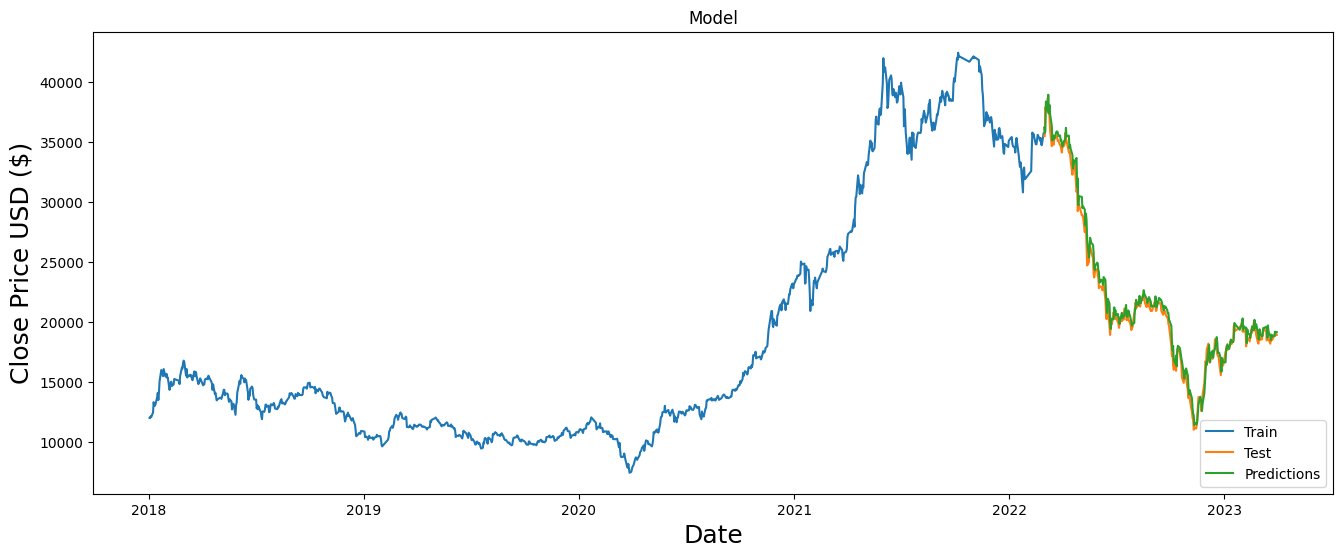

In [ ]:
train = df[:len(train_data)]
valid = df[len(train_data):]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Price'])
plt.plot(valid[['Price', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
valid[['Price', 'Predictions']]

,Price,Predictions
Date,,
2022-03-01,35495.0,36200.726562
2022-03-02,35495.0,35765.390625
2022-03-03,37916.9,35902.195312
2022-03-04,37689.8,38389.671875
2022-03-07,38673.7,37622.144531
...,...,...
2023-03-27,18909.0,18822.322266
2023-03-28,18818.0,19186.066406
2023-03-29,18909.0,19050.886719
